# CoinAPI

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.dates as mdates
import datetime

In [264]:
import requests
import json

with open('key', 'r') as file:
    ckey = file.read()
symbol_id = 'ADA'
period_id = '1DAY'
time_start = '2019-05-03T00:00:00'
time_end = '2021-05-09T00:00:00'
limit = '1000'

url = f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/USD/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'
#url = 'https://rest.coinapi.io/v1/symbols'

headers = {
  'Accepts': 'application/json',
  'X-CoinAPI-Key': ckey,
}


response = requests.get(url, headers=headers)
data = json.loads(response.text)

In [265]:
df = pd.DataFrame(data)
df = df.drop(['time_period_end', 'time_open', 'time_close'], axis=1)

In [266]:
df['Date'] = pd.to_datetime(df['time_period_start']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop(['time_period_start', 'Date'], axis=1)
df.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2019-05-03,0.067104,0.074000,0.066500,0.068826,1.105210e+07,1673
2019-05-04,0.069083,0.070949,0.065203,0.066269,8.567252e+06,1145
2019-05-05,0.066259,0.067266,0.064820,0.065500,3.166601e+06,388
2019-05-06,0.065252,0.068150,0.062891,0.066150,4.416848e+06,774
2019-05-07,0.066446,0.068239,0.062900,0.063100,5.940077e+06,1024


In [267]:
df.tail()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2021-05-04,1.3643,1.3681,1.257660,1.2719,1.145964e+08,186570
2021-05-05,1.2716,1.5000,1.260900,1.4813,2.003925e+08,283363
2021-05-06,1.4836,1.7050,1.426978,1.6503,3.079012e+08,443235
2021-05-07,1.6509,1.7499,1.530000,1.6551,2.001017e+08,342299
2021-05-08,1.6559,1.6569,1.563307,1.6250,1.123797e+08,238721


<AxesSubplot:xlabel='Date'>

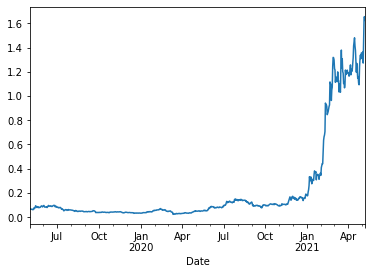

In [268]:
df['price_close'].plot()

## Simple Autoregression Model Selection Function

In [269]:
def hit_rate(true, pred):
    is_neg = lambda x: 0 if x > 0 else 1
    pos_true = []
    pos_hat = []
    for t in range(len(true)-1):
        pos_true.append(is_neg(np.sign(true[t] - true[t+1])))
        pos_hat.append(is_neg(np.sign(pred[t] - pred[t+1])))
    subtracted = np.abs(np.subtract(pos_hat, pos_true))
    rate = 1 - sum(subtracted)/len(subtracted)
    return rate

def find_returns(true, pred):
    ret_true = []
    ret_hat = []
    for t in range(len(true)-1):
        ret_true.append(((true[t+1] - true[t])/true[t])*100)
        ret_hat.append(((pred[t+1] - pred[t])/pred[t])*100)
    mse = mean_squared_error(ret_true, ret_hat)
    return ret_true, ret_hat, mse
        

def model_selection(data, forecast, dates, optimization='RET'):
    X_train, X_test = data[1:len(data)-forecast], data[len(data)-forecast:]
    dates_test = dates[len(dates)-forecast:]
    # find lag values which maximize hit rate
    rates = []
    for lag in range(1,int(len(X_train)/2)-1):
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = autoreg.forecast(forecast)
        rates.append(hit_rate(X_test, X_hat))
    
    max_hit_lags = [i for i, j in enumerate(rates) if j == max(rates)]
    
    # find lag values which maximize correct returns
    returns = []
    for lag in max_hit_lags:
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = np.exp(autoreg.forecast(forecast))
        returns.append(find_returns(np.exp(X_test), X_hat))
    
    if optimization == 'RET':
        mses = [ret[2] for ret in returns]
        min_mse_lags = [max_hit_lags[i] for i,j in enumerate(mses) if j == min(mses)]
        
    elif optimization == 'MSE':
        # find lag values which minimize close price MSE
        mses = []
        for lag in max_hit_lags:
            autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
            X_hat = autoreg.forecast(forecast)
            mses.append(mean_squared_error(X_test, X_hat))
    
        min_mse_lags = [max_hit_lags[i] for i, j in enumerate(mses) if j == min(mses)]
    
    best_returns = [returns[i] for i,j in enumerate(mses) if j == min(mses)]
    
    # Fit model
    lag_order = min_mse_lags[0]
    autoreg = AutoReg(X_train, lags=lag_order, old_names=True).fit()
    X_hat = autoreg.forecast(forecast)
    
    df_returns = pd.DataFrame(data={'returns_true':best_returns[0][0] , 'returns_pred':best_returns[0][1]})
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    ax.plot(dates_test, np.exp(X_test), marker='o', label='Observed')
    ax.plot(dates_test, np.exp(X_hat), marker='o', label='Predicted')
    fig.suptitle(f'{len(X_test)}-Day Prediction (Test Set)')
    ax.set_ylabel('Close Price (USD)')
    ax.set_xlabel('Date')
    ax.tick_params('x', labelsize=10)
    ax.legend()
    fig.autofmt_xdate()
    
    print("Lag:", lag_order)
    print("Hit rate:", rates[lag_order])
    print("Mean Squared Error:", min(mses))
    print(df_returns.head())
    
    
    return min_mse_lags[0]

## Transaction Cost / Profit

In [273]:
# Create a list of actions based on the percent change of the 
def hilo(pred_data):
    actions = []
    bought = False
    for t in range(len(pred_data)):
        if t == (len(pred_data)-1):
            if pred_data[t] > pred_data[t-1]:
                if bought:
                    actions.append((pred_data[t], 'sell'))
            else:
                if bought:
                    pass
                else:
                    actions.append((pred_data[t], 'wait'))
            continue
        if pred_data[t+1] >= pred_data[t]:
            if bought:
                actions.append((pred_data[t], 'hold'))
            else:
                actions.append((pred_data[t], 'buy'))
                bought = True
        else:
            if bought:
                actions.append((pred_data[t], 'sell'))
                bought = False
            else:
                actions.append((pred_data[t], 'wait'))
    return actions

def transactions(actions, returns, capital, fee=0.01):
    money = capital
    holdings = []
    total_percent = 0.0
    cost = capital
    r = 0
    for action in actions:
        if 'buy' in action[1]:
            cost += fee*money
            total_percent += returns[r]
            holdings.append(money)
        elif 'sell' in action[1]:
            money = money + (money*(total_percent/100))
            cost += fee*money
            total_percent = 0.0
            holdings.append(money)
        elif 'hold' in action[1]:
            total_percent += returns[r]
            holdings.append(money + (money*(total_percent/100)))
        else:
            holdings.append(money)
        r += 1
    return holdings, money - capital - (cost-capital), cost
            
def short_term_trade_ar(data, forecast, capital, dates, optimization='RET'):
    
    action_colors = {
        'buy': 'b',
        'sell': 'g',
        'hold': 'y',
        'wait': 'r'
    }
    
    # model selection (lag order based on minimization)
    lag_order = model_selection(data, forecast, dates, optimization)
    
    autoreg = AutoReg(X, lags=lag_order, old_names=True).fit()
    X_hat = np.exp(autoreg.forecast(forecast))
    
    # plotting new out-of-set prediction
    forecasted_dates = [dates[-1] + datetime.timedelta(days=t) for t in range(1,forecast+1)]
    
    trade_actions = hilo(X_hat)
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    ax.plot(forecasted_dates,X_hat, marker='o')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price (USD)')
    fig.suptitle(f'{forecast}-Day Forecast (Future Days)')
    ax.tick_params('x', labelsize=10)
    fig.autofmt_xdate()
    
    returns = []
    for t in range(len(X_hat)-1):
        returns.append(((X_hat[t+1] - X_hat[t])/X_hat[t])*100)
        
    prices, profit, cost = transactions(trade_actions, returns, capital)
    print(f"Profit (USD): {profit}")
    print(f"Trade Costs (USD): {cost}")
    
    df_actions = pd.DataFrame(trade_actions, columns=['close','action'])
    df_actions['percent_change'] = [0.0] + returns
    df_actions['value'] = prices
    df_actions.index = forecasted_dates
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    already_used = set()
    for p in range(len(forecasted_dates)):
        if df_actions['action'][p] not in already_used:
            ax.scatter(forecasted_dates[p], df_actions['value'][p], 
                       c=action_colors[df_actions['action'][p]], 
                       label=df_actions['action'][p])
            already_used.add(df_actions['action'][p])
        else:
            ax.scatter(forecasted_dates[p], df_actions['value'][p], 
                       c=action_colors[df_actions['action'][p]])
    ax.plot(forecasted_dates, df_actions['value'], zorder=0)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value (USD)')
    fig.suptitle(f'{forecast}-Day Forecast Trading')
    ax.tick_params('x', labelsize=10)
    fig.autofmt_xdate()
    ax.legend()
    
    return trade_actions, df_actions, profit, capital
        

Lag: 238
Hit rate: 0.8333333333333334
Mean Squared Error: 22.401915551358254
   returns_true  returns_pred
0      2.634749      2.542100
1     -6.711163      0.671148
2     16.463558     11.875107
3     11.408898      6.974363
4      0.290856      6.484449
Profit (USD): 30.773580670059104
Trade Costs (USD): 104.56260910010887


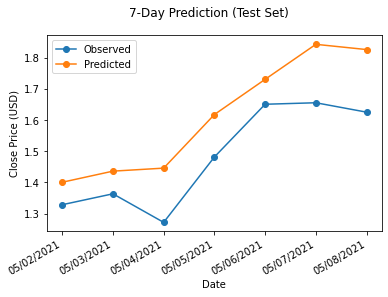

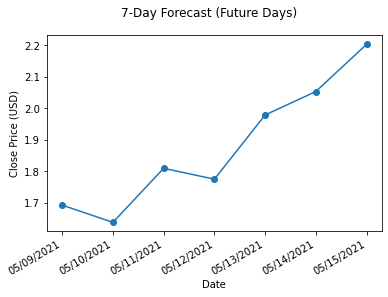

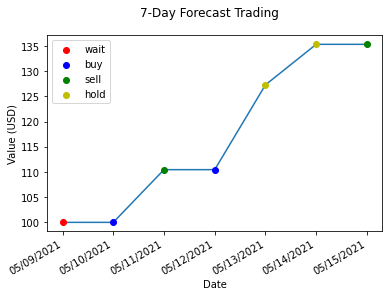

In [274]:
X = df['price_close'].apply(np.log).values
hilo_info, df_actions, profit, cost = short_term_trade_ar(X, 7, 100, df.index, 'RET')

In [272]:
df_actions

,close,action,percent_change,value
2021-05-09,1.692241,wait,0.000000,100.000000
2021-05-10,1.637697,buy,-3.223214,100.000000
2021-05-11,1.809038,sell,10.462360,110.462360
2021-05-12,1.774522,buy,-1.908016,110.462360
2021-05-13,1.978066,hold,11.470360,127.287055
2021-05-14,2.052457,hold,3.760797,135.336190
2021-05-15,2.202014,sell,7.286767,135.336190
